# Business Case 4: Cryptocurrencies Forecasting

## Contents:
  
 * [Modeling LINK](#Modeling)
 * [LINK - Entire Dataset](#entiredataset)
    * [Model 1: LSTM](#lstm)
    * [Model 2: XGBOOST Regressor](#xgboost)
 * [LINK - since January 2021](#jan2021)
    * [Model 1: LSTM](#lstm2)
    * [Model 2: XGBOOST Regressor](#xgboost2)
 * [LINK - since January 2022](#jan2022)
    * [Model 1: LSTM](#lstm3)
    * [Model 2: XGBOOST Regressor](#xgboost3)
 * [Predictions for the next two days using the best model](#predictions)
 * [Final Predictions](#finalpredictions)
 

## Imports

In [1]:
#! pip install xgboost
#! pip install fastai==0.7.0
#! pip install --upgrade tensorflow
#! pip install keras
#! pip install pystan
#! pip install ephem
#! pip install fbprophet

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from math import ceil
import math
import scipy.stats as stats
from itertools import cycle

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly

import json
import requests
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error , mean_absolute_error, explained_variance_score, r2_score
from tensorflow.keras import layers
from xgboost import XGBRegressor

import warnings

# Modeling - LINK <a name="Modeling"></a>
>In this step, we decided to implement algorithms (LSTM, XGBOOST Regressor) that can predict the closing price of LINK.

# LINK - Entire Dataset <a name="entiredataset"></a>

In [3]:
link = pd.read_csv('LINK.csv', index_col = 'Date')

In [4]:
link.head()

,close,volume,%D,spread,volatility,close_off_high,EUR/USD_close
Date,,,,,,,
2017-11-24,0.000916,0.000020,0.407882,0.001338,0.302441,0.999973,0.645889
2017-11-25,0.000686,0.000011,0.536328,0.000492,0.118046,0.999269,0.645889
2017-11-26,0.000723,0.000009,0.667296,0.000369,0.103798,0.999819,0.645889
2017-11-27,0.000748,0.000023,0.628122,0.000267,0.086569,0.999918,0.685035
2017-11-28,0.000599,0.000028,0.632137,0.000398,0.106493,0.999065,0.673386


# Model 1: LSTM <a name="lstm"></a>

In [5]:
data = link.copy()

In [6]:
data.head()

,close,volume,%D,spread,volatility,close_off_high,EUR/USD_close
Date,,,,,,,
2017-11-24,0.000916,0.000020,0.407882,0.001338,0.302441,0.999973,0.645889
2017-11-25,0.000686,0.000011,0.536328,0.000492,0.118046,0.999269,0.645889
2017-11-26,0.000723,0.000009,0.667296,0.000369,0.103798,0.999819,0.645889
2017-11-27,0.000748,0.000023,0.628122,0.000267,0.086569,0.999918,0.685035
2017-11-28,0.000599,0.000028,0.632137,0.000398,0.106493,0.999065,0.673386


In [7]:
#Splitting the original dataset using all the variables (hist) and "close" (target) using 7 days a the length of the sliding window

hist = []
target = []
length = 7

for i in range(len(data)-length):
    t = data['close']
    v = data[['close', 'volume', 'volatility', 'close_off_high', 'EUR/USD_close']]
    x = v[i:i+length]
    y = t[i+length]
    hist.append(x)
    target.append(y)

In [8]:
print(len(hist[0]))  #nr of days
print(len(hist)) #size of train dataset
print(len(target)) #size of test dataset

7
1607
1607


In [9]:
#convert lists to arrays
hist = np.array(hist)
target = np.array(target)

In [10]:
target = target.reshape(-1,1)
target.shape

(1607, 1)

In [11]:
#Splitting the datasets into train and test using 80% for train and 20% for test

training_size=int(len(data)*0.80)

X_train = hist[:training_size,:]
X_test = hist[training_size:,:]

y_train = target[:training_size]
y_test = target[training_size:]

In [12]:
#Nr of instances, # nr of days (length), #nr of columns
X_train.shape

(1291, 7, 5)

In [13]:
model = tf.keras.Sequential()

model.add(layers.LSTM(units=20, activation = 'relu', return_sequences=True,
                  input_shape=(7,5), dropout = 0.2))

model.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))

model.add(layers.LSTM(units=40, activation = 'relu', dropout=0.2))

#model.add(layers.LSTM(units=55, return_sequences = True, dropout = 0.2))

#model.add(layers.LSTM(units = 80, activation = 'relu', dropout = 0.2))

model.add(layers.Dense(units=1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 20)             2080      
                                                                 
 lstm_1 (LSTM)               (None, 7, 32)             6784      
                                                                 
 lstm_2 (LSTM)               (None, 40)                11680     
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 20,585
Trainable params: 20,585
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, shuffle = False, validation_split=0.2)

Epoch 1/30
33/33 [==============================] - 6s 34ms/step - loss: 0.0019 - val_loss: 0.1474
Epoch 2/30
33/33 [==============================] - 0s 13ms/step - loss: 0.0075 - val_loss: 0.2041
Epoch 3/30
33/33 [==============================] - 0s 11ms/step - loss: 0.0040 - val_loss: 0.1938
Epoch 4/30
33/33 [==============================] - 0s 10ms/step - loss: 0.0042 - val_loss: 0.1913
Epoch 5/30
33/33 [==============================] - 0s 9ms/step - loss: 0.0040 - val_loss: 0.1887
Epoch 6/30
33/33 [==============================] - 0s 10ms/step - loss: 0.0040 - val_loss: 0.1838
Epoch 7/30
33/33 [==============================] - 0s 10ms/step - loss: 0.0039 - val_loss: 0.1778
Epoch 8/30
33/33 [==============================] - 0s 9ms/step - loss: 0.0039 - val_loss: 0.1676
Epoch 9/30
33/33 [==============================] - 0s 10ms/step - loss: 0.0038 - val_loss: 0.1526
Epoch 10/30
33/33 [==============================] - 0s 10ms/step - loss: 0.0036 - val_loss: 0.1266
Epoch 11/30

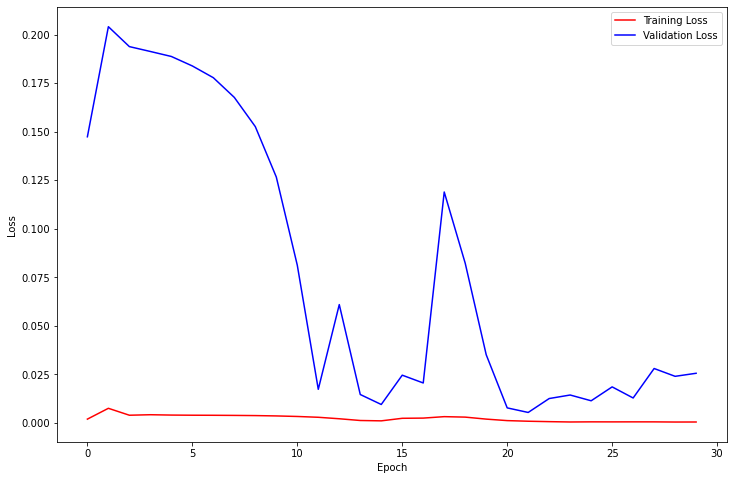

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_count = range(len(loss))
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r', label='Training loss')
plt.plot(epoch_count, val_loss, 'b', label='Validation loss')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [17]:
pred_test = model.predict(X_test)
pred_train = model.predict (X_train)

In [18]:
results = np.concatenate((y_test, pred_test), axis=1)
results = pd.DataFrame(results, columns = ['y_test', 'Predictions'])
a = data['close'].tail(len(pred_test))
a = list(a.index)
results['Date'] = a
results['Date'] = pd.to_datetime(results['Date'])
results.tail()

,y_test,Predictions,Date
311,0.258263,0.220348,2022-04-21
312,0.258659,0.221253,2022-04-22
313,0.253556,0.220498,2022-04-23
314,0.252475,0.218889,2022-04-24
315,0.255765,0.218834,2022-04-25


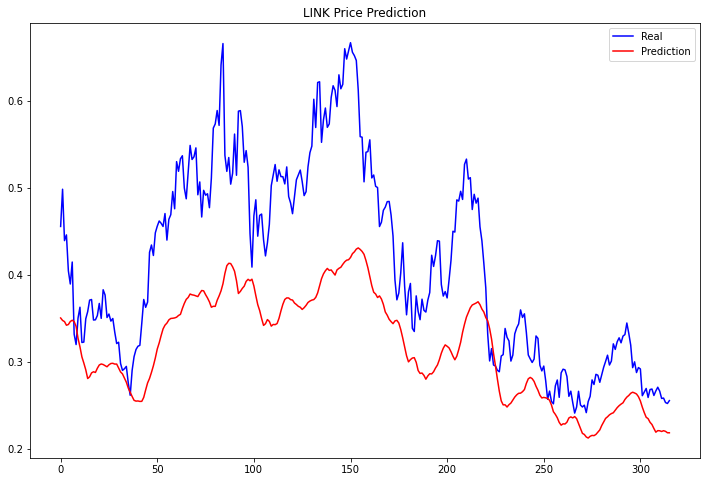

In [19]:
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(pred_test, color='red', label='Prediction')
plt.title('LINK Price Prediction')
plt.legend()
plt.show()

In [20]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,pred_train)))
print("Train data MSE: ", mean_squared_error(y_train,pred_train))
print("Train data MAE: ", mean_absolute_error(y_train,pred_train))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,pred_test)))
print("Test data MSE: ", mean_squared_error(y_test,pred_test))
print("Test data MAE: ", mean_absolute_error(y_test,pred_test))

Train data RMSE:  0.07257969699014608
Train data MSE:  0.005267812415181419
Train data MAE:  0.028258692633334807
-------------------------------------------------------------------------------------
Test data RMSE:  0.1142660499802671
Test data MSE:  0.013056730178092899
Test data MAE:  0.09680292593137192


In [21]:
print("Train data R2 score:", r2_score(y_train, pred_train))
print("Test data R2 score:", r2_score(y_test, pred_test))

Train data R2 score: 0.856829208207366
Test data R2 score: -0.036010469992410865


# Model 2: XGBoost Regressor  <a name="xgboost"></a>

In [22]:
data1 = link.copy()
data1.reset_index(inplace = True)
data1.shape

(1614, 8)

In [23]:
close_stock = data1.copy()
print("Total data for prediction: ",data1.shape[0])

Total data for prediction:  1614


In [24]:
data1.set_index('Date', inplace = True)
data1.shape

(1614, 7)

In [25]:
#Train and test split using 80% for train and 20% for test
training_size=int(len(data1)*0.80)
test_size=len(data1)-training_size
train_data,test_data=data1.iloc[:training_size,:],data1.iloc[training_size:,:]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (1291, 7)
test_data:  (323, 7)


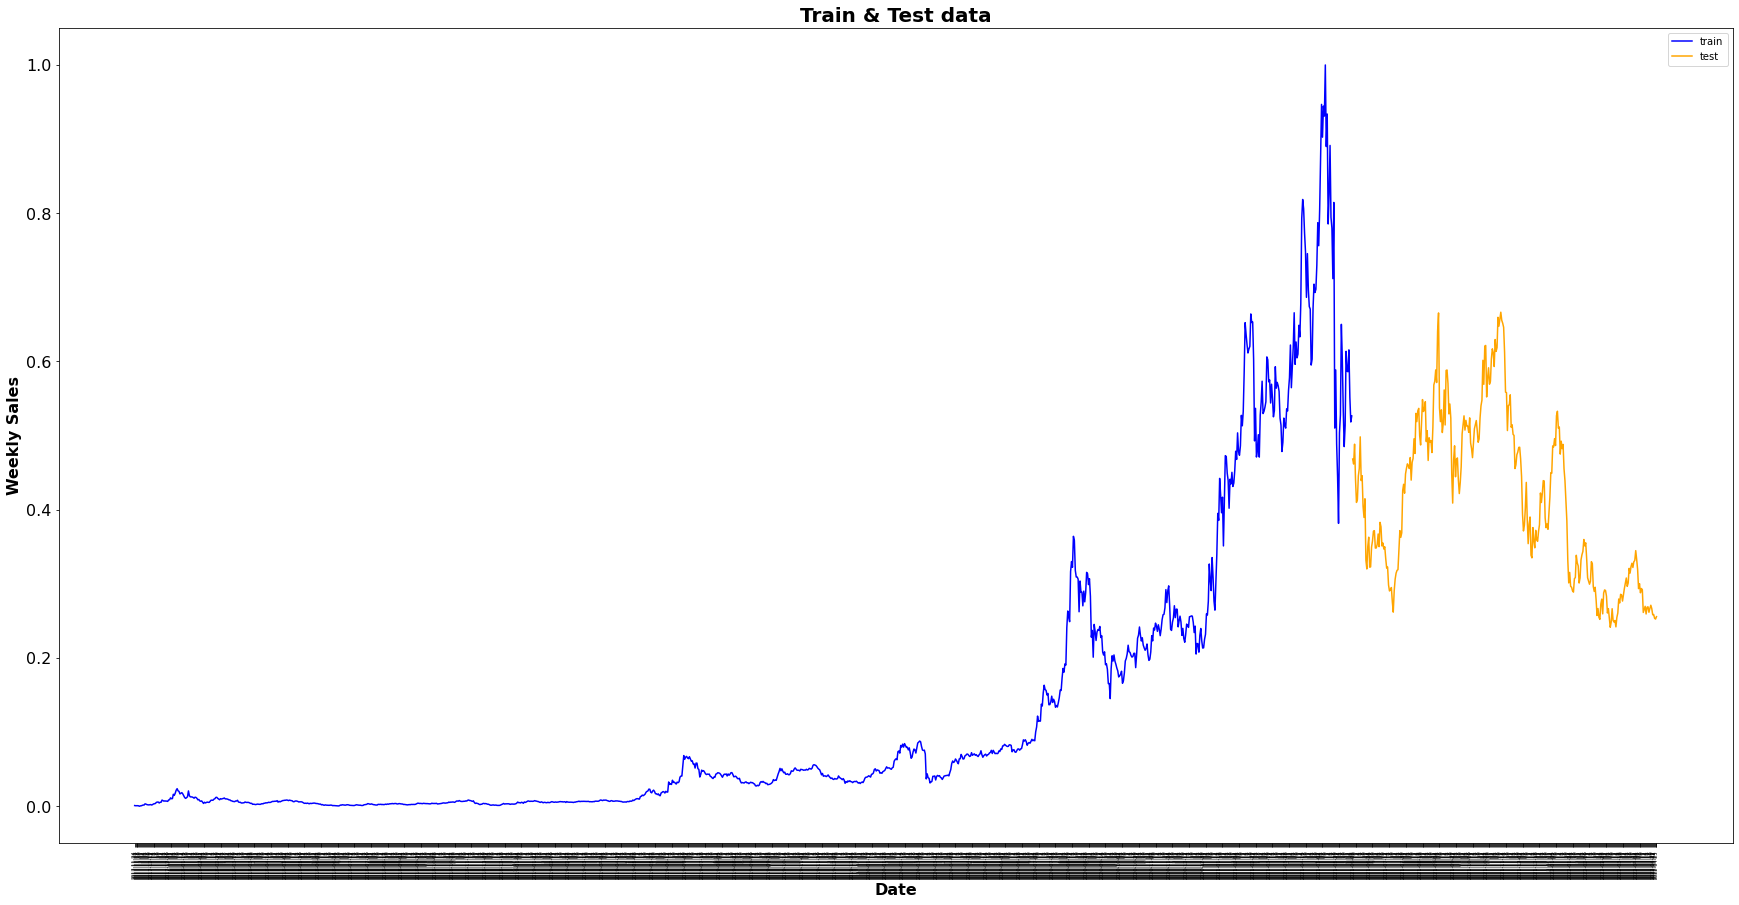

In [26]:
data1.reset_index(inplace = True)
fig, ax = plt.subplots(figsize=(30, 15))
sns.lineplot(x = close_stock['Date'][:training_size], y = close_stock['close'][:training_size], color = 'blue')
sns.lineplot(x = close_stock['Date'][training_size:], y = close_stock['close'][training_size:], color = 'orange')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', labelsize=5)
plt.xticks(rotation='vertical')
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

In [27]:
data1.set_index('Date', inplace = True)

In [28]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset.iloc[i:(i+time_step), 1:]   
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [29]:
#Sliding window = 7 or 20
time_step = 7
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (1283, 7, 6)
y_train:  (1283,)
X_test:  (315, 7, 6)
y_test (315,)


In [30]:
#Reshaping the arrays because XGBRegressor only accepts 1-Dimensional arrays
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [31]:
model1 = XGBRegressor(n_estimators=100, random_state = 1, eta = 0.2)
model1.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.2,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.200000003, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=1, reg_alpha=0, ...)

In [32]:
predictions = model1.predict(X_test).reshape(-1,1)
y_test = y_test.reshape(-1,1)

predictions_train = model1.predict(X_train)

In [33]:
results2 = np.concatenate((y_test, predictions),axis = 1)
results2 = pd.DataFrame(results2, columns = ['y_test', 'Predictions'])
a = data1['close'].tail(len(predictions))
a = list(a.index)
results2['Date'] = a
results2['Date'] = pd.to_datetime(results2['Date'])
results2.tail()

,y_test,Predictions,Date
310,0.266626,0.065382,2022-04-21
311,0.258263,0.070216,2022-04-22
312,0.258659,0.066150,2022-04-23
313,0.253556,0.066771,2022-04-24
314,0.252475,0.051914,2022-04-25


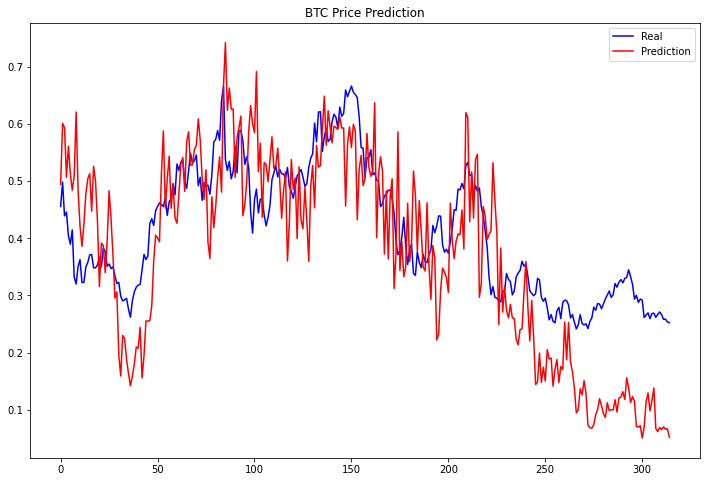

In [34]:
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(predictions, color='red', label='Prediction')
plt.title('BTC Price Prediction')
plt.legend()
plt.show()

In [35]:
print("Train data MSE: ", mean_squared_error(y_train,predictions_train))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_train, predictions_train)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_train, predictions_train))))
print('R^2 Score', r2_score(y_train, predictions_train))

print ("--------------------------------------------------------------")
print("Test data MSE: ", mean_squared_error(y_test,predictions))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))
print('R^2 Score', r2_score(y_test, predictions))

Train data MSE:  4.448766806764896e-07
Mean Absolute Error - MAE : 0.0004748834777665648
Root Mean squared Error - RMSE : 0.0006669907650608737
R^2 Score 0.9999877457675953
--------------------------------------------------------------
Test data MSE:  0.01310217154575144
Mean Absolute Error - MAE : 0.09458644465506855
Root Mean squared Error - RMSE : 0.11446471747115546
R^2 Score -0.042851586535093134


# LINK- since January 2021  <a name="jan2021"></a>

# Model 1: LSTM <a name="lstm2"></a>

In [36]:
data2 = link.copy()
data2.reset_index(inplace = True)
data2 = data2[data2['Date'] >= '2021-01-01']
data2.set_index('Date', inplace = True)
print("Total data for prediction: ",data2.shape[0])

Total data for prediction:  480


In [37]:
hist = []
target = []
length = 7

for i in range(len(data2)-length):
    t = data2['close']
    v = data2[['close','volume','volatility', 'close_off_high', 'EUR/USD_close']]
    x = v[i:i+length]
    y = t[i+length]
    hist.append(x)
    target.append(y)

In [38]:
print(len(hist[0]))
print(len(hist))
print(len(target))

7
473
473


In [39]:
#convert list to array
hist = np.array(hist)
target = np.array(target)

In [40]:
target = target.reshape(-1,1)
target.shape

(473, 1)

In [41]:
training_size = int(len(data2)*0.8)

X_train = hist[:training_size,:]
X_test = hist[training_size:,:]

y_train = target[:training_size]
y_test = target[training_size:]

In [42]:
X_train.shape

(384, 7, 5)

In [43]:
model2 = tf.keras.Sequential()

model2.add(layers.LSTM(units=20, activation = 'relu', return_sequences=True,
                  input_shape=(7,5), dropout = 0.2))

model2.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))

model2.add(layers.LSTM(units=32, activation = 'relu', dropout=0.2))

#model.add(layers.LSTM(units=55, return_sequences = True, dropout = 0.2))

#model.add(layers.LSTM(units = 80, activation = 'relu', dropout = 0.2))

model2.add(layers.Dense(units=1))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 7, 20)             2080      
                                                                 
 lstm_4 (LSTM)               (None, 7, 32)             6784      
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 17,217
Trainable params: 17,217
Non-trainable params: 0
_________________________________________________________________


In [44]:
model2.compile(optimizer='adam', loss='mean_squared_error')

In [45]:
history = model2.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, shuffle = False)

Epoch 1/30
10/10 [==============================] - 4s 68ms/step - loss: 0.2756 - val_loss: 0.1591
Epoch 2/30
10/10 [==============================] - 0s 13ms/step - loss: 0.1961 - val_loss: 0.0853
Epoch 3/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0774 - val_loss: 0.0056
Epoch 4/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0304 - val_loss: 0.0092
Epoch 5/30
10/10 [==============================] - 0s 10ms/step - loss: 0.0204 - val_loss: 0.0071
Epoch 6/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0207 - val_loss: 0.0060
Epoch 7/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0172 - val_loss: 0.0078
Epoch 8/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0162 - val_loss: 0.0063
Epoch 9/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0171 - val_loss: 0.0061
Epoch 10/30
10/10 [==============================] - 0s 10ms/step - loss: 0.0168 - val_loss: 0.0067
Epoch 11/

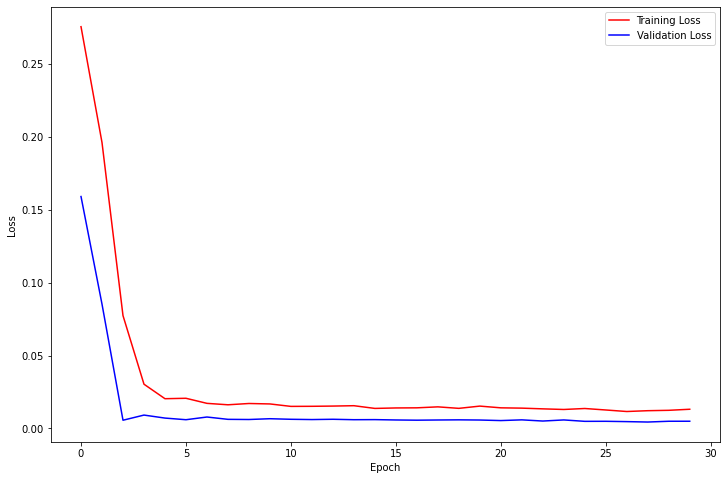

In [46]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_count = range(len(loss))
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r', label='Training loss')
plt.plot(epoch_count, val_loss, 'b', label='Validation loss')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [47]:
pred_test = model2.predict(X_test)
pred_train = model2.predict (X_train)

In [48]:
results = np.concatenate((y_test, pred_test), axis=1)
results = pd.DataFrame(results, columns = ['y_test', 'Predictions'])
a = data2['close'].tail(len(pred_test))
a = list(a.index)
results['Date'] = a
results['Date'] = pd.to_datetime(results['Date'])
results.tail()
results.head()

,y_test,Predictions,Date
0,0.288843,0.423048,2022-01-27
1,0.306954,0.419624,2022-01-28
2,0.308542,0.420233,2022-01-29
3,0.338561,0.421330,2022-01-30
4,0.328416,0.420109,2022-01-31


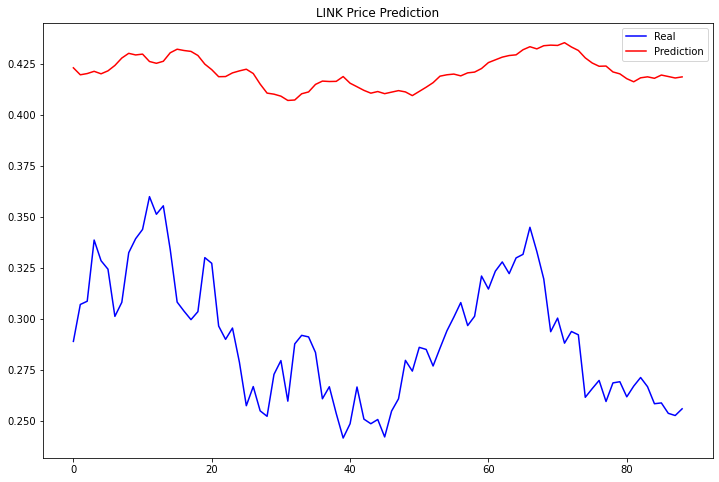

In [49]:
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(pred_test, color='red', label='Prediction')
plt.title('LINK Price Prediction')
plt.legend()
plt.show()

In [50]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,pred_train)))
print("Train data MSE: ", mean_squared_error(y_train,pred_train))
print("Train data MAE: ", mean_absolute_error(y_train,pred_train))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,pred_test)))
print("Test data MSE: ", mean_squared_error(y_test,pred_test))
print("Test data MAE: ", mean_absolute_error(y_test,pred_test))

Train data RMSE:  0.09146511068397176
Train data MSE:  0.008365866472431205
Train data MAE:  0.06916827561985191
-------------------------------------------------------------------------------------
Test data RMSE:  0.13324414958075037
Test data MSE:  0.017754003397497376
Test data MAE:  0.13060210741111727


In [51]:
print("Train data R2 score:", r2_score(y_train, pred_train))
print("Test data R2 score:", r2_score(y_test, pred_test))

Train data R2 score: 0.509390571388902
Test data R2 score: -18.370596556194975


# Model 2: XGBoost Regressor   <a name="xgboost2"></a>

In [52]:
data3 = link.copy()

In [53]:
data3.reset_index(inplace = True)
data3 = data3[data3['Date'] >= '2021-01-01']               
data3.set_index('Date', inplace = True)
print("Total data for prediction: ",data3.shape[0])

Total data for prediction:  480


In [54]:
data3.shape

(480, 7)

In [55]:
training_size=int(len(data3)*0.80)
test_size=len(data3)-training_size
train_data,test_data=data3.iloc[:training_size,:],data3.iloc[training_size:,:]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (384, 7)
test_data:  (96, 7)


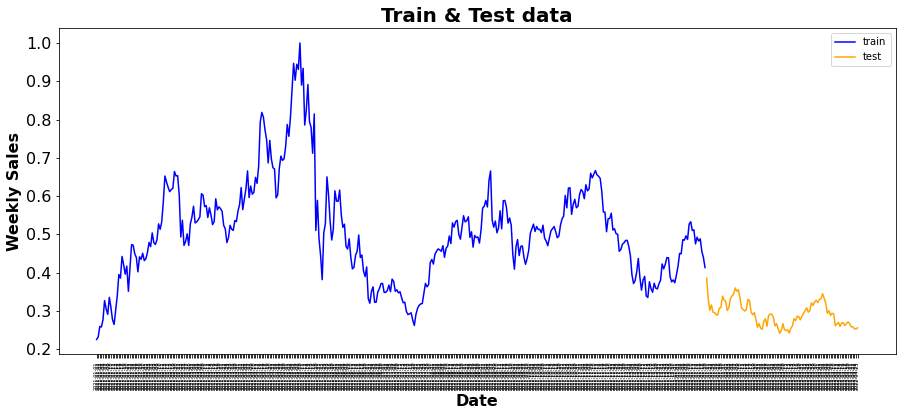

In [56]:
data3.reset_index(inplace = True)
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = data3['Date'][:training_size], y = data3['close'][:training_size], color = 'blue')
sns.lineplot(x = data3['Date'][training_size:], y =data3['close'][training_size:], color = 'orange')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=5)
plt.xticks(rotation = 'vertical')
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

In [57]:
data3.set_index('Date', inplace = True)

In [58]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset.iloc[i:(i+time_step), :]   
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [59]:
time_step = 7
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (376, 7, 7)
y_train:  (376,)
X_test:  (88, 7, 7)
y_test (88,)


In [60]:
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [61]:
model3 = XGBRegressor(n_estimators=1000, random_state = 1, eta = 0.2)
model3.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.2,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.200000003, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
             reg_alpha=0, ...)

In [62]:
predictions = model3.predict(X_test).reshape(-1,1)
y_test = y_test.reshape(-1,1)

predictions_train = model3.predict(X_train).reshape(-1,1)
y_train = y_train.reshape(-1,1)

In [63]:
results2 = np.concatenate((y_test, predictions), axis = 1)
results2 = pd.DataFrame(results2, columns = ['y_test', 'Predictions'])
a = data3['close'].tail(len(predictions))
a = list(a.index)
results2['Date'] = a
results2['Date'] = pd.to_datetime(results2['Date'])
results2.tail()

,y_test,Predictions,Date
83,0.266626,0.310774,2022-04-21
84,0.258263,0.304839,2022-04-22
85,0.258659,0.296757,2022-04-23
86,0.253556,0.313464,2022-04-24
87,0.252475,0.298363,2022-04-25


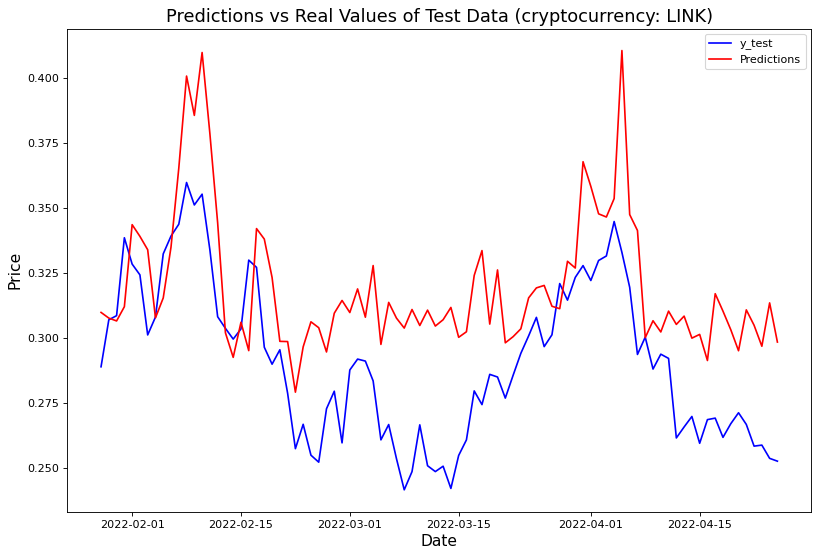

In [64]:
plt.figure(figsize = (12,8), dpi = 80)
plt.plot(results2['Date'], results2['y_test'], 'b', label = 'y_test')
plt.plot(results2['Date'], results2['Predictions'], 'r', label = 'Predictions')
plt.title ('Predictions vs Real Values of Test Data (cryptocurrency: LINK)', fontsize = 16, )
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Price', fontsize = 14)
plt.legend()

plt.show()

In [65]:
print("Train data MSE: ", mean_squared_error(y_train,predictions_train))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_train, predictions_train)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_train, predictions_train))))
print('R^2 Score', r2_score(y_train, predictions_train))

print ("--------------------------------------------------------------")
print("Test data MSE: ", mean_squared_error(y_test,predictions))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))
print('R^2 Score', r2_score(y_test, predictions))

Train data MSE:  3.8555962873499457e-07
Mean Absolute Error - MAE : 0.00045236531663738025
Root Mean squared Error - RMSE : 0.0006209344802271771
R^2 Score 0.9999768791851074
--------------------------------------------------------------
Test data MSE:  0.0012971911926393804
Mean Absolute Error - MAE : 0.030891027851483656
Root Mean squared Error - RMSE : 0.03601654054235887
R^2 Score -0.42064322026835255


# LINK - since January 2022  <a name="jan2022"></a>

# Model 1: LSTM <a name="lstm3"></a>

In [66]:
data4 = link.copy()
data4.reset_index(inplace = True)
data4 = data4[data4['Date'] >= '2022-01-01']
data4.set_index('Date', inplace = True)
print("Total data for prediction: ",data4.shape[0])

Total data for prediction:  115


In [67]:
hist = []
target = []
length = 7

for i in range(len(data4)-length):
    t = data4['close']
    v = data4[['close','volume', 'volatility', 'close_off_high', 'EUR/USD_close']]
    x = v[i:i+length]
    y = t[i+length]
    hist.append(x)
    target.append(y)

In [68]:
print(len(hist[0]))
print(len(hist))
print(len(target))

7
108
108


In [69]:
#convert list to array
hist = np.array(hist)
target = np.array(target)

In [70]:
target = target.reshape(-1,1)
target.shape

(108, 1)

In [71]:
training_size = int(len(data4)*0.8)

X_train = hist[:training_size,:]
X_test = hist[training_size:,:]

y_train = target[:training_size]
y_test = target[training_size:]

In [72]:
X_train.shape

(92, 7, 5)

In [73]:
model4 = tf.keras.Sequential()

model4.add(layers.LSTM(units=20, activation = 'relu', return_sequences=True,
                  input_shape=(7,5), dropout = 0.2))

model4.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))

model4.add(layers.LSTM(units=32, activation = 'relu', dropout=0.2))

#model.add(layers.LSTM(units=55, return_sequences = True, dropout = 0.2))

#model.add(layers.LSTM(units = 80, activation = 'relu', dropout = 0.2))

model4.add(layers.Dense(units=1))

model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 7, 20)             2080      
                                                                 
 lstm_7 (LSTM)               (None, 7, 32)             6784      
                                                                 
 lstm_8 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 17,217
Trainable params: 17,217
Non-trainable params: 0
_________________________________________________________________


In [74]:
model4.compile(optimizer='adam', loss='mean_squared_error')

In [75]:
history = model4.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, shuffle = False)

Epoch 1/30
3/3 [==============================] - 4s 257ms/step - loss: 0.1088 - val_loss: 0.0748
Epoch 2/30
3/3 [==============================] - 0s 22ms/step - loss: 0.0802 - val_loss: 0.0500
Epoch 3/30
3/3 [==============================] - 0s 22ms/step - loss: 0.0561 - val_loss: 0.0284
Epoch 4/30
3/3 [==============================] - 0s 21ms/step - loss: 0.0347 - val_loss: 0.0119
Epoch 5/30
3/3 [==============================] - 0s 20ms/step - loss: 0.0172 - val_loss: 0.0020
Epoch 6/30
3/3 [==============================] - 0s 20ms/step - loss: 0.0086 - val_loss: 9.3372e-04
Epoch 7/30
3/3 [==============================] - 0s 19ms/step - loss: 0.0103 - val_loss: 0.0044
Epoch 8/30
3/3 [==============================] - 0s 18ms/step - loss: 0.0144 - val_loss: 0.0031
Epoch 9/30
3/3 [==============================] - 0s 18ms/step - loss: 0.0084 - val_loss: 7.2669e-04
Epoch 10/30
3/3 [==============================] - 0s 21ms/step - loss: 0.0056 - val_loss: 3.6662e-04
Epoch 11/30
3/3 

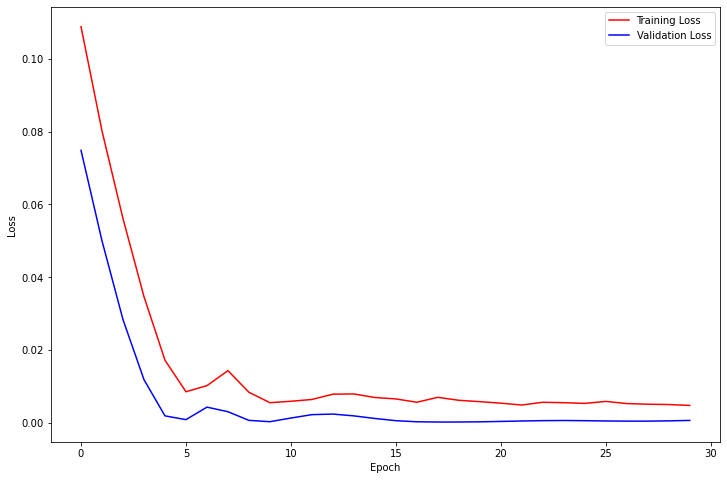

In [76]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_count = range(len(loss))
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r', label='Training loss')
plt.plot(epoch_count, val_loss, 'b', label='Validation loss')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [77]:
pred_test = model4.predict(X_test)
pred_train = model4.predict (X_train)

In [78]:
results = np.concatenate((y_test, pred_test), axis=1)
results = pd.DataFrame(results, columns = ['y_test', 'Predictions'])
a = data4['close'].tail(len(pred_test))
a = list(a.index)
results['Date'] = a
results['Date'] = pd.to_datetime(results['Date'])
results.tail()

,y_test,Predictions,Date
11,0.258263,0.279427,2022-04-21
12,0.258659,0.279628,2022-04-22
13,0.253556,0.279150,2022-04-23
14,0.252475,0.278703,2022-04-24
15,0.255765,0.279340,2022-04-25


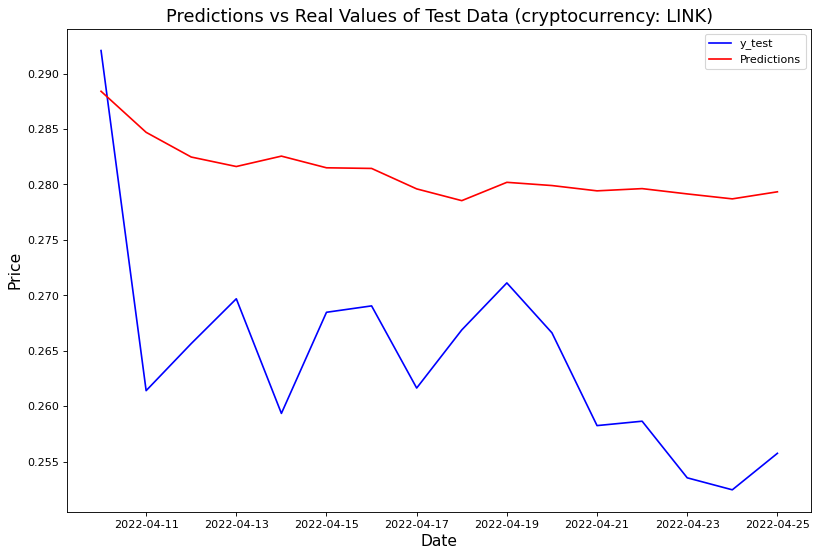

In [79]:
plt.figure(figsize = (12,8), dpi = 80)
plt.plot(results['Date'], results['y_test'], 'b', label = 'y_test')
plt.plot(results['Date'], results['Predictions'], 'r', label = 'Predictions')
plt.title ('Predictions vs Real Values of Test Data (cryptocurrency: LINK)', fontsize = 16,)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Price', fontsize = 14)
plt.legend()

plt.show()

In [80]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,pred_train)))
print("Train data MSE: ", mean_squared_error(y_train,pred_train))
print("Train data MAE: ", mean_absolute_error(y_train,pred_train))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,pred_test)))
print("Test data MSE: ", mean_squared_error(y_test,pred_test))
print("Test data MAE: ", mean_absolute_error(y_test,pred_test))

Train data RMSE:  0.06220488980186555
Train data MSE:  0.0038694483152622366
Train data MAE:  0.04021733057787004
-------------------------------------------------------------------------------------
Test data RMSE:  0.018277486142993474
Test data MSE:  0.00033406649970731843
Test data MAE:  0.01711237084823857


In [81]:
print("Train data R2 score:", r2_score(y_train, pred_train))
print("Test data R2 score:", r2_score(y_test, pred_test))

Train data R2 score: 0.21385886024703404
Test data R2 score: -2.9975471231229767


# Model 2: XGBoost Regressor   <a name="xgboost3"></a>

In [82]:
data5= link.copy()
data5.reset_index(inplace = True)
data5 = data5[data5['Date'] >= '2022-01-01']
data5.set_index('Date', inplace = True)
print("Total data for prediction: ",data5.shape[0])

Total data for prediction:  115


In [83]:
training_size=int(len(data5)*0.80)
test_size=len(data5)-training_size
train_data,test_data=data5.iloc[:training_size,:],data5.iloc[training_size:,:]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (92, 7)
test_data:  (23, 7)


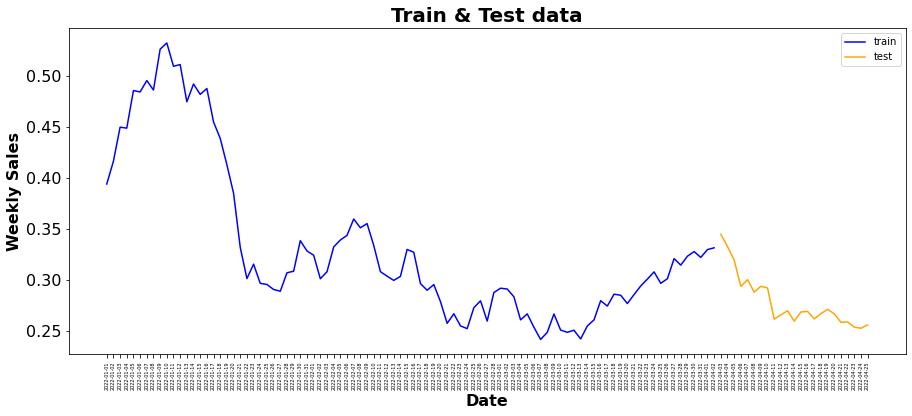

In [84]:
data5.reset_index(inplace = True)
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = data5['Date'][:training_size], y = data5['close'][:training_size], color = 'blue')
sns.lineplot(x = data5['Date'][training_size:], y = data5['close'][training_size:], color = 'orange')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=5)
plt.xticks(rotation = 'vertical')
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

In [85]:
data5.set_index('Date', inplace = True)

In [86]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset.iloc[i:(i+time_step), :]   
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [87]:
time_step = 7
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (84, 7, 7)
y_train:  (84,)
X_test:  (15, 7, 7)
y_test (15,)


In [88]:
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [89]:
model5 = XGBRegressor(n_estimators=1000, random_state = 1, eta = 0.2)
model5.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.2,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.200000003, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
             reg_alpha=0, ...)

In [90]:
predictions = model5.predict(X_test).reshape(-1,1)
y_test = y_test.reshape(-1,1)


predictions_train = model5.predict(X_train).reshape(-1,1)
y_train = y_train.reshape(-1,1)

In [91]:
results2 = np.concatenate((y_test, predictions), axis = 1)
results2 = pd.DataFrame(results2, columns = ['y_test', 'Predictions'])
a = data5['close'].tail(len(predictions))
a = list(a.index)
results2['Date'] = a
results2['Date'] = pd.to_datetime(results2['Date'])
results2.tail()

,y_test,Predictions,Date
10,0.266626,0.283068,2022-04-21
11,0.258263,0.279156,2022-04-22
12,0.258659,0.268417,2022-04-23
13,0.253556,0.277652,2022-04-24
14,0.252475,0.269885,2022-04-25


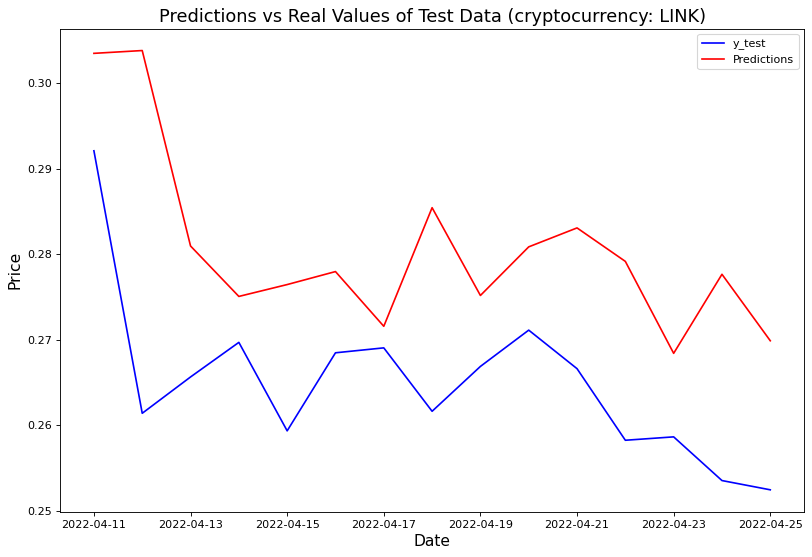

In [92]:
plt.figure(figsize = (12,8), dpi = 80 )
plt.plot(results2['Date'], results2['y_test'], 'b', label = 'y_test')
plt.plot(results2['Date'], results2['Predictions'], 'r', label = 'Predictions')
plt.title ('Predictions vs Real Values of Test Data (cryptocurrency: LINK)', fontsize = 16, )
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Price', fontsize = 14)
plt.legend()

plt.show()

In [93]:
print("Train data MSE: ", mean_squared_error(y_train,predictions_train))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_train, predictions_train)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_train, predictions_train))))
print('R^2 Score', r2_score(y_train, predictions_train))

print ("--------------------------------------------------------------")
print("Test data MSE: ", mean_squared_error(y_test,predictions))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))
print('R^2 Score', r2_score(y_test, predictions))

Train data MSE:  1.8057127051544732e-07
Mean Absolute Error - MAE : 0.00031226656678972183
Root Mean squared Error - RMSE : 0.0004249367841402381
R^2 Score 0.99996619903637
--------------------------------------------------------------
Test data MSE:  0.0003327161488581212
Mean Absolute Error - MAE : 0.01559401218961044
Root Mean squared Error - RMSE : 0.018240508459418592
R^2 Score -2.9698994675872887


# Predictions for the next two days using the best model <a name="predictions"></a>

In [94]:
#Importing the dataset with the updated data
#Use just the 7 past rows, because our model is predicting based on this sliding window
predictions = pd.read_csv('test_LINK.csv', index_col = 'Date')

In [95]:
predictions.tail(7)

,close,volume,%D,spread,volatility,close_off_high,EUR/USD_close
Date,,,,,,,
2022-05-02,0.211965,0.002621,0.060433,0.025233,0.052067,0.985747,0.015836
2022-05-03,0.210864,0.002373,0.078627,0.025116,0.052586,0.982107,0.002421
2022-05-04,0.230539,0.002940,0.167915,0.046125,0.112595,0.999938,0.012130
2022-05-05,0.206944,0.003286,0.156303,0.067161,0.156027,0.921321,0.058967
2022-05-06,0.204686,0.002974,0.163360,0.021822,0.044790,0.988561,0.017718
2022-05-07,0.193929,0.002076,0.049167,0.031900,0.074940,0.965640,0.017718
2022-05-08,0.190171,0.002524,0.040855,0.018496,0.038689,0.982127,0.017718


In [96]:
predictions1 = predictions.tail(7)
predictions1 = np.array(predictions1)

In [97]:
x_input=predictions1[len(predictions1)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

output9=[]
n_steps=7
i=0
pred_days = 1


In [98]:
while(i<pred_days):
    
    if(len(temp_input)>time_step):        
        x_input=np.array(temp_input[i:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = model3.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[i:]
       
        output9.extend(yhat.tolist())
        i=i+1
        
print("Output of predicted next days: ", len(output9))

0 day input [0.21196533 0.00262126 0.0604334  0.02523274 0.05206726 0.98574734
 0.01583568 0.21086353 0.00237324 0.07862678 0.02511586 0.05258638
 0.98210672 0.00242126 0.23053913 0.00294025 0.16791467 0.04612489
 0.11259492 0.99993801 0.01213009 0.20694396 0.00328607 0.15630311
 0.06716103 0.15602687 0.92132082 0.05896673 0.20468558 0.00297368
 0.16336005 0.02182243 0.04479008 0.98856118 0.01771789 0.19392859
 0.00207612 0.04916715 0.03189985 0.07493967 0.96563977 0.01771789
 0.19017096 0.0025245  0.04085515 0.01849638 0.03868863 0.98212676
 0.01771789]
0 day output [0.29086345]
Output of predicted next days:  1


In [99]:
output9  #predicted closing price for May 9th, 2022 (Monday)

[0.2908634543418884]

In [100]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[1 2 3 4 5 6 7]
[8]


In [101]:
# Inserting the prediction for the row May 9th, 2022 --> using new predicted value + data from May 8th 2022 for the other variables 

In [102]:
a = predictions.tail(1).copy()
a.reset_index(inplace = True)
a

,Date,close,volume,%D,spread,volatility,close_off_high,EUR/USD_close
0,2022-05-08,0.190171,0.002524,0.040855,0.018496,0.038689,0.982127,0.017718


In [103]:
a.at[0,'Date']='2022-05-09'
a.at[0,'close']= output9[0]
a.set_index('Date', inplace = True)
a

,close,volume,%D,spread,volatility,close_off_high,EUR/USD_close
Date,,,,,,,
2022-05-09,0.290863,0.002524,0.040855,0.018496,0.038689,0.982127,0.017718


In [104]:
final_predictions = pd.concat([predictions, a], axis=0, join='outer')

In [105]:
#Get the predicted denormalized closing price using MinMaxScaler formula
intermediate_result = ((52.19896-0.145255)*output9[0])+0.145255

print ("The predicted closing price for LINK on May 9th, 2022 is ", intermediate_result, "USD")

The predicted closing price for LINK on May 9th, 2022 is  15.28577544759363 USD


# Final Predictions<a name="finalpredictions"></a>

In [106]:
final_predictions.tail(7)

,close,volume,%D,spread,volatility,close_off_high,EUR/USD_close
Date,,,,,,,
2022-05-03,0.210864,0.002373,0.078627,0.025116,0.052586,0.982107,0.002421
2022-05-04,0.230539,0.002940,0.167915,0.046125,0.112595,0.999938,0.012130
2022-05-05,0.206944,0.003286,0.156303,0.067161,0.156027,0.921321,0.058967
2022-05-06,0.204686,0.002974,0.163360,0.021822,0.044790,0.988561,0.017718
2022-05-07,0.193929,0.002076,0.049167,0.031900,0.074940,0.965640,0.017718
2022-05-08,0.190171,0.002524,0.040855,0.018496,0.038689,0.982127,0.017718
2022-05-09,0.290863,0.002524,0.040855,0.018496,0.038689,0.982127,0.017718


In [107]:
final_predictions1 = final_predictions.tail(7)
final_predictions1 = np.array(final_predictions1)

In [108]:
x_input=(final_predictions1[len(final_predictions1)-(time_step*time_step):]).reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

output10=[]
n_steps=7
i=0
pred_days = 1

In [109]:
while(i<pred_days):
    
    if(len(temp_input)>time_step):        
        x_input=np.array(temp_input[i:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = model3.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[i:]
       
        output10.extend(yhat.tolist())
        i=i+1
        
print("Output of predicted next days: ", len(output10))

0 day input [0.21086353 0.00237324 0.07862678 0.02511586 0.05258638 0.98210672
 0.00242126 0.23053913 0.00294025 0.16791467 0.04612489 0.11259492
 0.99993801 0.01213009 0.20694396 0.00328607 0.15630311 0.06716103
 0.15602687 0.92132082 0.05896673 0.20468558 0.00297368 0.16336005
 0.02182243 0.04479008 0.98856118 0.01771789 0.19392859 0.00207612
 0.04916715 0.03189985 0.07493967 0.96563977 0.01771789 0.19017096
 0.0025245  0.04085515 0.01849638 0.03868863 0.98212676 0.01771789
 0.29086345 0.0025245  0.04085515 0.01849638 0.03868863 0.98212676
 0.01771789]
0 day output [0.29616386]
Output of predicted next days:  1


In [110]:
print ("The predicted normalized closing price for LINK on May 10th, 2022 is ", output10[0])

The predicted normalized closing price for LINK on May 10th, 2022 is  0.2961638569831848


In [111]:
#Get the predicted denormalized closing price using MinMaxScaler formula
final_result = ((52.19896-0.145255)*output10[0])+0.145255

print ("The predicted closing price for LINK on May 10th, 2022 is ", final_result, "USD")

The predicted closing price for LINK on May 10th, 2022 is  15.561681043064894 USD
